In [1]:
#jtplot.style(theme='monokai',context='talk')

# Prédiction de la qualité d'un vin à partir de ses composants chimiques

### Import des librairies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from mlxtend.plotting import plot_confusion_matrix
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA

## Objectif 1 : arriver à prédire la qualité d'un vin
### Import du dataset 

In [3]:
wine = pd.read_csv('winequality-red.csv')

In [4]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Etude du dataset

In [5]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


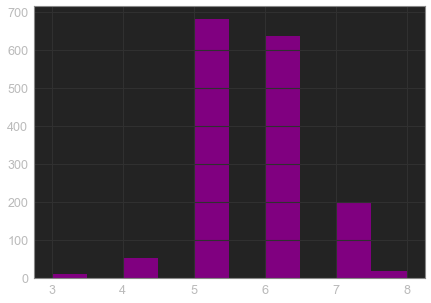

In [6]:
wine['quality'].hist(figsize=(7,5), color="purple")
plt.savefig('histograms_wines.png')
plt.show()

In [7]:
wine['quality'].value_counts(sort=False)/1599*100

3     0.625391
4     3.314572
5    42.589118
6    39.899937
7    12.445278
8     1.125704
Name: quality, dtype: float64

In [8]:
wine['quality'].describe()

count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

Les notes vont de 3/10 à 8/10.
La distribution de la target est décalée vers la droite. La moyenne est à 5.65, la médiane à 6. 
96% des vins ont une note égale ou supérieure à 5/10
Le vin peut être considéré comme de bonne qualité en général pour ce dataset.

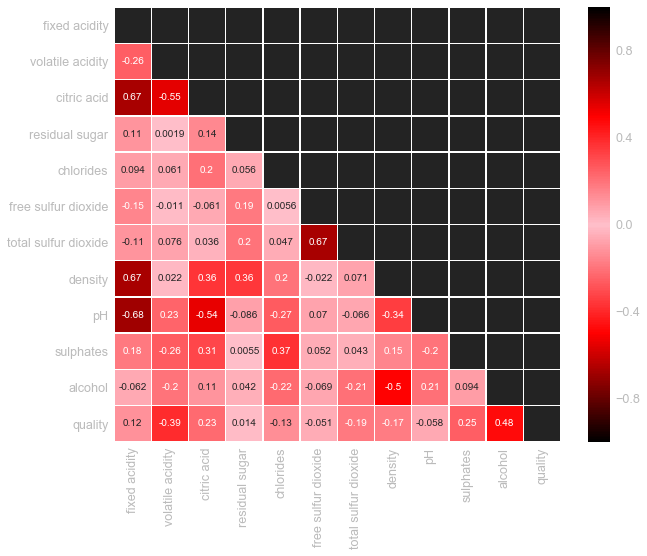

In [9]:
wine_corr = wine.corr()
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['black','red','pink','red','black'])
mask = np.zeros_like(wine_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(wine_corr, xticklabels=wine_corr.columns, yticklabels=wine_corr.columns, cmap=cmap,linewidths = .5, annot=True, ax=ax, mask=mask, vmin=-1)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('correlation_table_wine.png')
plt.show()

In [10]:
wine.drop(columns=['free sulfur dioxide','pH'], inplace=True)

Suppression de free sulfur dioxide qui est très peu corrélé à la target et qui est inclus dans total sulfur dioxide.
Supression du pH qui est une mesure d'acidité comprise dans les colonnes fixed et volatile acidity. (Lorsque je créée une colonne total acidity qui combine les 2 genres d'acidité, mon score baisse...)

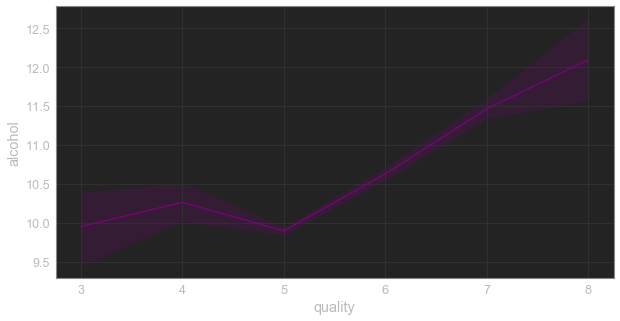

In [11]:
f, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x="quality", y="alcohol", data=wine, color='purple')
plt.savefig('alcohol_vs_quality.png')

### Scalling

In [12]:
X = wine.drop(columns = ['quality'])
y = wine['quality']

In [13]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

### Modèles et prédictions

#### Linear SVC 

In [14]:
linearsvc = LinearSVC(dual=False)
pred_svc=cross_val_predict(linearsvc, X, y, cv=10)

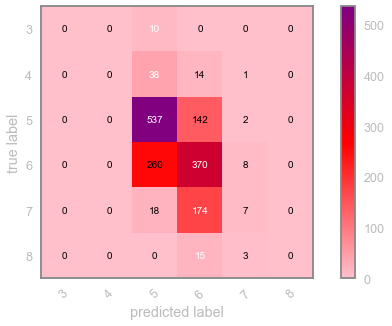

In [59]:
cmap2 = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['pink','red','purple'])
cm = confusion_matrix(y, pred_svc)
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=['3','4','5','6','7','8'],figsize=(10, 5), cmap=cmap2, colorbar=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('confusion_matrix_obj1_SVC.png')
plt.show()

In [60]:
print('Accuracy score :',accuracy_score(y, pred_svc))

Accuracy score : 0.5716072545340838


In [61]:
print('F1 score:\n',classification_report(y, pred_svc, digits=3))

F1 score:
               precision    recall  f1-score   support

           3      0.000     0.000     0.000        10
           4      0.000     0.000     0.000        53
           5      0.622     0.789     0.696       681
           6      0.517     0.580     0.547       638
           7      0.333     0.035     0.064       199
           8      0.000     0.000     0.000        18

    accuracy                          0.572      1599
   macro avg      0.246     0.234     0.218      1599
weighted avg      0.513     0.572     0.522      1599



C:\Users\aline\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### RandomForest 

Recherche des meilleurs hyperparamètres avec Randomized search et Grid search

In [62]:
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [1, 3, 5, None],
              "max_features": sp_randint(1, 10),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=10, iid=False)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [1, 3, 5, None],
              "max_features": [2, 3, 9],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10, iid=False)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

RandomizedSearchCV took 29.24 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.587 (std: 0.048)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 8, 'min_samples_split': 4}

Model with rank: 2
Mean validation score: 0.584 (std: 0.072)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 4, 'min_samples_split': 8}

Model with rank: 3
Mean validation score: 0.583 (std: 0.053)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 7, 'min_samples_split': 9}

GridSearchCV took 139.51 seconds for 144 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.598 (std: 0.059)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 3, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.597 (std: 0.056)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'max_feat

In [63]:
rfc = RandomForestClassifier(n_estimators=20, bootstrap=True, 
criterion='gini', max_depth=5,max_features=3,min_samples_split=10)
pred_rfc=cross_val_predict(rfc, X, y, cv=10)

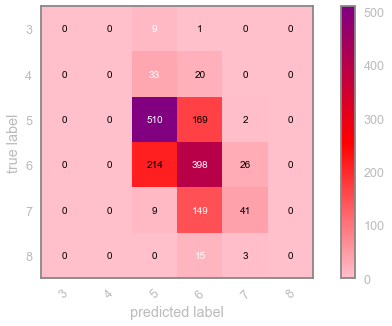

In [64]:
cm = confusion_matrix(y, pred_rfc)
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=['3','4','5','6','7','8'],figsize=(10, 5), cmap=cmap2, colorbar=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('confusion_matrix_obj1_RFC.png')
plt.show()

In [65]:
print('Accuracy score :',accuracy_score(y, pred_rfc))

Accuracy score : 0.5934959349593496


In [66]:
print('F1 score:\n',classification_report(y, pred_rfc, digits=3))

F1 score:
               precision    recall  f1-score   support

           3      0.000     0.000     0.000        10
           4      0.000     0.000     0.000        53
           5      0.658     0.749     0.701       681
           6      0.529     0.624     0.573       638
           7      0.569     0.206     0.303       199
           8      0.000     0.000     0.000        18

    accuracy                          0.593      1599
   macro avg      0.293     0.263     0.263      1599
weighted avg      0.562     0.593     0.565      1599



C:\Users\aline\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### XGBoost

In [67]:
xgboost = XGBClassifier(objective='multi:softmax', num_class=10, 
        n_jobs=-1,booster="gbtree",tree_method = "hist",
        grow_policy = "depthwise")
pred_xgboost=cross_val_predict(xgboost, X, y, cv=10)

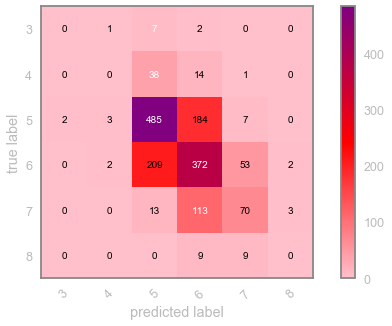

In [68]:
cm = confusion_matrix(y, pred_xgboost)
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=['3','4','5','6','7','8'],figsize=(10, 5), cmap=cmap2, colorbar=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('confusion_matrix_obj_XGBoost.png')
plt.show()

In [69]:
print('Accuracy score :',accuracy_score(y, pred_xgboost))

Accuracy score : 0.5797373358348968


In [70]:
print('F1 score :\n',classification_report(y, pred_xgboost, digits=3))

F1 score :
               precision    recall  f1-score   support

           3      0.000     0.000     0.000        10
           4      0.000     0.000     0.000        53
           5      0.645     0.712     0.677       681
           6      0.536     0.583     0.559       638
           7      0.500     0.352     0.413       199
           8      0.000     0.000     0.000        18

    accuracy                          0.580      1599
   macro avg      0.280     0.275     0.275      1599
weighted avg      0.551     0.580     0.563      1599



#### Distribution des classes

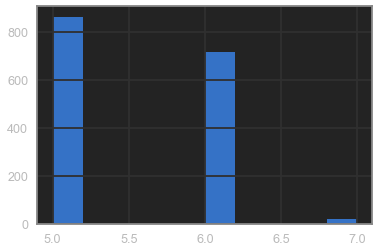

In [71]:
X['pred_svc'] = pred_svc
X['pred_svc'].hist()
plt.savefig('distribution_obj1_svc.png')

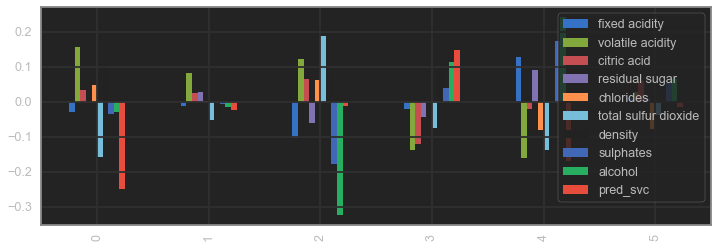

In [72]:
linearsvc.fit(X, y)
feature=X.columns
importance= linearsvc.coef_
feat_imp = pd.DataFrame(importance, columns=X.columns)
feat_imp.plot(kind = "bar", figsize=(12,4))
plt.savefig('feature-importance_obj1_svc.png')

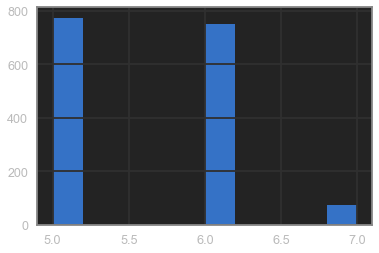

In [73]:
X['pred_rfc'] = pred_rfc
X['pred_rfc'].hist()
plt.savefig('distribution_obj1_rfc.png')

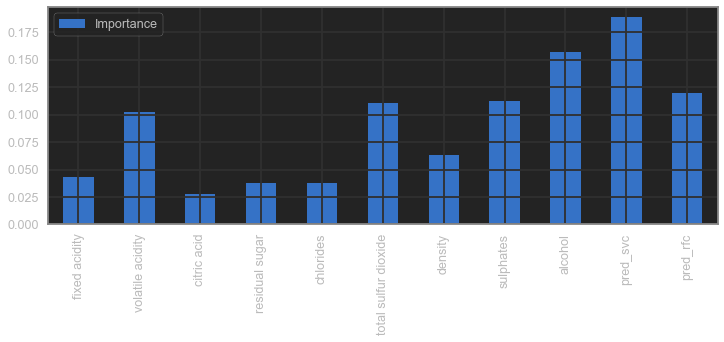

In [74]:
rfc.fit(X, y)
feature=X.columns
importance=rfc.feature_importances_
feat_imp = pd.DataFrame(importance, feature, columns=['Importance'])
feat_imp.plot(kind = "bar", figsize=(12,4))
plt.savefig('feature-importance_obj1_rfc.png')

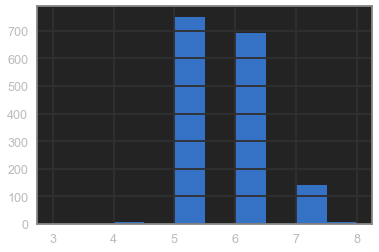

In [75]:
X['pred_xgboost'] = pred_xgboost
X['pred_xgboost'].hist()
plt.savefig('distribution_obj1_xgboost.png')

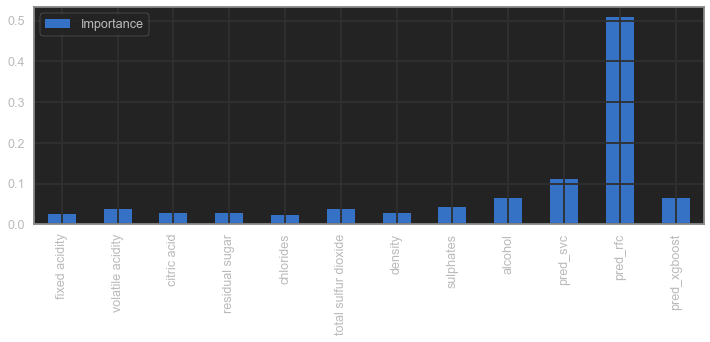

In [76]:
xgboost.fit(X, y)
feature=X.columns
importance=xgboost.feature_importances_
feat_imp = pd.DataFrame(importance, feature, columns=['Importance'])
feat_imp.plot(kind = "bar", figsize=(12,4))
plt.savefig('feature-importance_obj1_xgboost.png')

## Objectif 2 : arriver à prédire si un vin est bon ou mauvais (binaire)

In [77]:
wine = pd.read_csv('winequality-red.csv')
pd.set_option('mode.chained_assignment', None)

### Classement de la colonne 'Quality' en 0 et 1

In [78]:
wine.quality[wine['quality']<=5]=0
wine.quality[wine['quality']>5]=1

In [79]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Comme pour l'objectif 1 : pas besoin de feature enginering car les données sont toutes numériques, nécessaires (pas de corrélation entre elles supérieures à 70%)

### Scalling et split

In [80]:
X = wine.drop(columns = ['quality'])
y = wine['quality']

In [81]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

### Modèles et prédictions 

#### Linear SVC 

In [82]:
linearsvc = LinearSVC(dual=False)
pred_svc=cross_val_predict(linearsvc, X, y, cv=10)

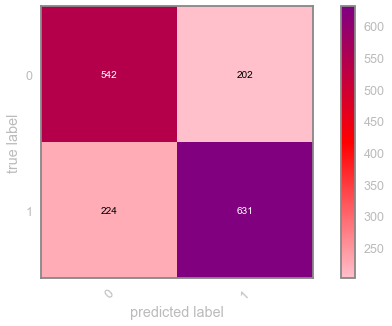

In [83]:
cmap2 = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['pink','red','purple'])
cm = confusion_matrix(y, pred_svc)
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=['0','1'],figsize=(10, 5), cmap=cmap2, colorbar=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('confusion_matrix_obj2_SVC.png')
plt.show()

In [84]:
print('Accuracy score :',accuracy_score(y, pred_svc))

Accuracy score : 0.7335834896810507


In [85]:
print('F1 score :\n',classification_report(y, pred_svc, digits=3))

F1 score :
               precision    recall  f1-score   support

           0      0.708     0.728     0.718       744
           1      0.758     0.738     0.748       855

    accuracy                          0.734      1599
   macro avg      0.733     0.733     0.733      1599
weighted avg      0.734     0.734     0.734      1599



#### RandomForest 

In [86]:
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [1, 3, 5, None],
              "max_features": sp_randint(1, 10),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=10, iid=False)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [1, 3, 5, None],
              "max_features": [2, 3, 9],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10, iid=False)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

RandomizedSearchCV took 16.67 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.741 (std: 0.067)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 4, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.736 (std: 0.078)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 8, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.734 (std: 0.065)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 5, 'min_samples_split': 7}

GridSearchCV took 118.19 seconds for 144 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.744 (std: 0.068)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.743 (std: 0.069)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 

In [87]:
rfc = RandomForestClassifier(n_estimators=20, bootstrap=True, criterion='gini', max_depth=3,max_features=4,min_samples_split=10)
pred_rfc=cross_val_predict(rfc, X, y, cv=10)

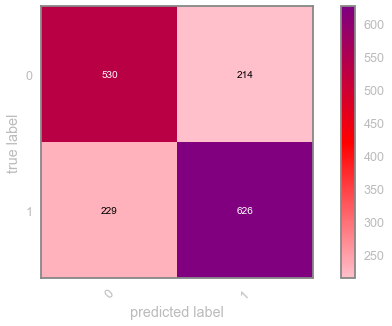

In [88]:
cm = confusion_matrix(y, pred_rfc)
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=['0','1'],figsize=(10, 5), cmap=cmap2, colorbar=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('confusion_matrix_obj2_RFC.png')
plt.show()

In [89]:
print('Accuracy score :',accuracy_score(y, pred_rfc))

Accuracy score : 0.7229518449030644


In [90]:
print('F1 score:\n',classification_report(y, pred_rfc, digits=3))

F1 score:
               precision    recall  f1-score   support

           0      0.698     0.712     0.705       744
           1      0.745     0.732     0.739       855

    accuracy                          0.723      1599
   macro avg      0.722     0.722     0.722      1599
weighted avg      0.723     0.723     0.723      1599



#### XGBoost

In [91]:
xgboost = XGBClassifier(objective='reg:squarederror', n_jobs=-1,
                        booster="gbtree",tree_method = "hist",
                        grow_policy = "depthwise")
pred_xgboost=cross_val_predict(xgboost, X, y, cv=10)

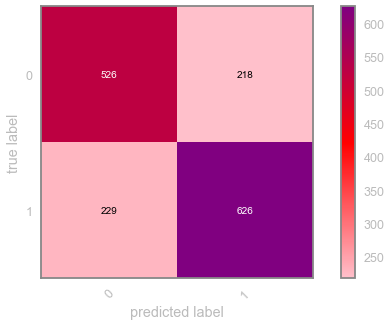

In [92]:
cm = confusion_matrix(y, pred_xgboost)
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=['0','1'],figsize=(10, 5), cmap=cmap2, colorbar=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('confusion_matrix_obj2_XGBoost.png')
plt.show()

In [93]:
print('Accuracy score :',accuracy_score(y, pred_xgboost))

Accuracy score : 0.7204502814258912


In [94]:
print('F1 score :\n',classification_report(y, pred_xgboost, digits=3))

F1 score :
               precision    recall  f1-score   support

           0      0.697     0.707     0.702       744
           1      0.742     0.732     0.737       855

    accuracy                          0.720      1599
   macro avg      0.719     0.720     0.719      1599
weighted avg      0.721     0.720     0.721      1599



#### Distribution des classes

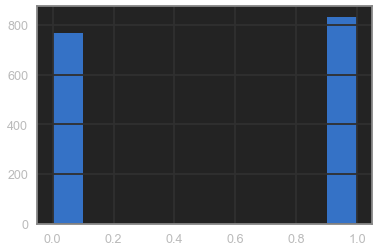

In [95]:
X['pred_svc'] = pred_svc
X['pred_svc'].hist()
plt.savefig('distribution_obj2_svc.png')

In [96]:
feature=X.columns
importance= linearsvc.coef_
feat_imp = pd.DataFrame(importance, columns=feature)
feat_imp.plot(kind = "bar", figsize=(12,4))
plt.savefig('feature-importance_obj2_svc.png')

AttributeError: 'LinearSVC' object has no attribute 'coef_'

In [ ]:
X['pred_rfc'] = pred_rfc
X['pred_rfc'].hist()
plt.savefig('distribution_obj2_rfc.png')

In [ ]:
rfc.fit(X, y)
feature=X.columns
importance=rfc.feature_importances_
feat_imp = pd.DataFrame(importance, feature, columns=['Importance'])
feat_imp.plot(kind = "bar", figsize=(12,4))
plt.savefig('feature-importance_obj2_rfc.png')

In [ ]:
X['pred_xgboost'] = pred_xgboost
X['pred_xgboost'].hist()
plt.savefig('distribution_obj2_xgboost.png')

In [ ]:
xgboost.fit(X, y)
feature=X.columns
importance=xgboost.feature_importances_
feat_imp = pd.DataFrame(importance, feature, columns=['Importance'])
feat_imp.plot(kind = "bar", figsize=(12,4))
plt.savefig('feature-importance_obj2_xgboost.png')

Conclusion : la qualité du vin du dataset était considéré comme supérieur à la moyenne, ce que l'algorithme Random Forest a réussi à démontrer avec des hyperparamètres ciblés, malgré la faible quantité de données (1599 entrées)